# ACTUAL STUFF

In [ ]:
# import os
# import torch

# import numpy as np
# from torchvision.io import read_image
# from torchvision import tv_tensors
# from torchvision.transforms.v2 import functional as F


# class DetectDataset(torch.utils.data.Dataset):
#     def __init__(self, root, transforms):
#         self.root = root
#         self.transforms = transforms
#         self.img_names = list(os.listdir(os.path.join(root, "images")))

#     def __getitem__(self, idx):
#         # load images and boxes
#         img_name = self.img_names[idx]
#         boxes_name = img_name[:-4] + '.txt'
#         img_path = os.path.join(self.root, "images", img_name)
#         boxes_path = os.path.join(self.root, "labels", boxes_name)
#         img = read_image(img_path)
#         boxes = np.loadtxt(boxes_path)

#         # get num objexts, image_id, area and iscrowd
#         labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
#         num_objs = len(boxes) # number of objects in image
#         image_id = idx # doesnt matter
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # area of box
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # just set to zero

#         # Wrap sample and targets into torchvision tv_tensors:
#         img = tv_tensors.Image(img)

#         target = {}
#         target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

#     def __len__(self):
#         return len(self.img_names)

In [45]:
# how to define dataset: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.ssdlite320_mobilenet_v3_large.html
# follow link and click on See ssd300_vgg16() for more details.

import os
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


class DetectDataset(Dataset):
    def __init__(self, root, inds):
        self.root = root
        self.img_names = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.img_names = [self.img_names[i] for i in inds]

    def __getitem__(self, idx):
        # load images and boxes
        img_name = self.img_names[idx]
        boxes_name = img_name[:-4] + '.txt'
        img_path = os.path.join(self.root, "images", img_name)
        boxes_path = os.path.join(self.root, "labels", boxes_name)
        img = Image.open(img_path).convert("RGB")       
        boxes = np.loadtxt(boxes_path)
        if boxes.ndim == 1:
            boxes = boxes[None, :]
        labels = torch.ones((len(boxes),), dtype=torch.int64) # there is only one class

        target = {}
        target["boxes"] = torch.from_numpy(boxes)
        target["labels"] = labels

        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.img_names)

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
base_dir = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment'
images_dir = os.path.join(base_dir, 'images')
train_inds, val_inds = train_test_split(range(len(os.listdir(images_dir))), test_size=0.1)


def custom_collate(data):
    return data

trainset = DetectDataset(base_dir, train_inds)
valset = DetectDataset(base_dir, val_inds)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=custom_collate)
valloader = DataLoader(valset, batch_size=16, collate_fn=custom_collate)

In [47]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

# # bigger model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1).to(device)
# num_classes = 2 # background is also a class here
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)


# smaller model
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=torchvision.models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT, trainable_backbone_layers=5).to(device)
num_classes = 2  # 1 class (your class) + 1 class (background)
model.head.classification_head.num_classes = num_classes

In [48]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=0.001)

In [49]:
len(trainset)

873

In [50]:
len(valset)

98

In [ ]:
num_epochs = 20



for epoch in range(num_epochs):
    train_epoch_loss = 0
    model.train()

    for data in trainloader:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['labels'].to(device)
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # train_epoch_loss = train_epoch_loss / len(trainset)

    
    if epoch % 1 == 0:
        val_epoch_loss = 0

        with torch.no_grad():
            for data in valloader:
                imgs = []
                targets = []
                for d in data:
                    imgs.append(d[0].to(device))
                    targ = {}
                    targ['boxes'] = d[1]['boxes'].to(device)
                    targ['labels'] = d[1]['labels'].to(device)
                    targets.append(targ)

                loss_dict = model(imgs, targets)
                loss = sum(v for v in loss_dict.values())
                val_epoch_loss += loss.cpu().detach().numpy()
            
            # val_epoch_loss = val_epoch_loss / len(valset)
    
    print(f'trainloss: {train_epoch_loss}')
    print(f'valloss: {val_epoch_loss}')

In [136]:
model.eval()
data = next(iter(valloader))


In [137]:
img = data[0][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['labels']

In [138]:
output = model([img.to(device)])

In [139]:
output

[{'boxes': tensor([[ 66.3785, 149.8098, 170.1534, 270.7100],
          [323.5798,  69.5732, 462.0901, 160.6879],
          [ 99.1912, 298.4297, 222.0603, 376.1382],
          [447.5157, 123.3887, 554.8962, 184.6376],
          [ 86.9529,  19.7145, 248.3017,  78.1995],
          [ 25.8557, 305.3485, 132.1509, 370.6415],
          [243.6201,  30.5658, 295.6194, 160.3084],
          [557.4489,  79.6067, 639.7755, 139.9002],
          [441.8201,  82.8784, 552.7933, 133.2124],
          [ 43.8145,  28.7345, 216.2264,  89.3405],
          [ 39.1859,  34.8205, 142.4402,  89.3279],
          [444.7334,  99.9624, 554.0266, 162.1340],
          [ 44.8777,  20.8889, 270.5256, 107.0486],
          [591.8589,  71.3545, 639.6797, 134.1243],
          [498.3378,  82.1401, 615.9760, 134.5982],
          [602.1251, 294.0123, 637.3687, 367.9832],
          [587.0870,  43.9892, 640.0000, 114.9778],
          [395.9879, 124.7752, 552.8916, 206.0572],
          [261.3148,  37.2024, 315.4426, 126.8498],
   

In [140]:
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']
keep = torchvision.ops.nms(out_bbox, out_scores, 0.4)
keep = keep.detach().cpu().numpy()

In [141]:
out_bbox.shape, keep.shape

(torch.Size([54, 4]), (33,))

In [142]:
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')

In [143]:
import PIL

In [144]:
keep

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 14, 15, 16, 18, 20, 21, 24,
       26, 27, 29, 30, 31, 34, 35, 36, 37, 40, 41, 43, 46, 47, 48, 53])

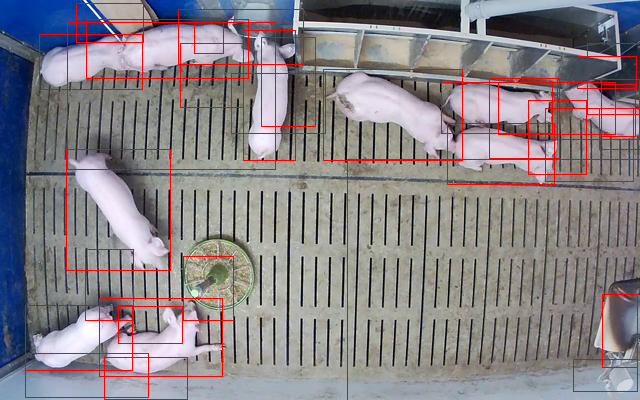

In [145]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

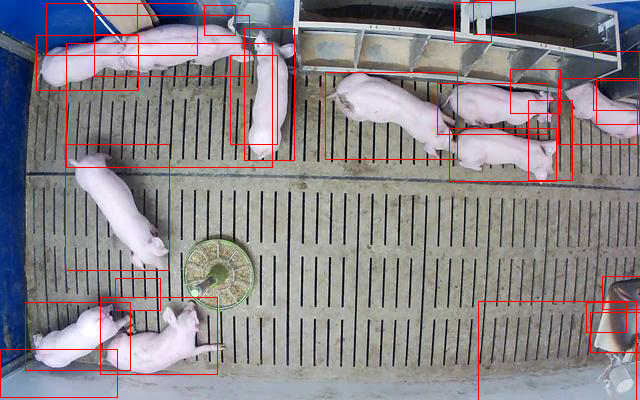

In [106]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

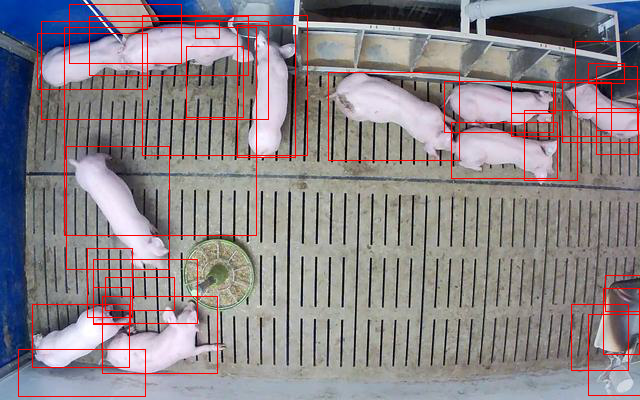

In [90]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

# HUGGING FACE DETR

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6, 7"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [1]:
from datasets import load_dataset
import os

base_dir = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment'
train_path = os.path.join(base_dir, 'train.csv')
val_path = os.path.join(base_dir, 'val.csv')
data_files = {
    'train': train_path,
    'val': val_path
}

dataset = load_dataset("csv", data_files=data_files)
print(dataset['train'])
print(dataset['val'])

id2label = {0: 'pig'}
label2id = {'pig': 0}

Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 873
})
Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 98
})


In [2]:
from transformers import AutoImageProcessor, YolosImageProcessor

# checkpoint = "facebook/detr-resnet-50"
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)

checkpoint = "hustvl/yolos-tiny"
image_processor = YolosImageProcessor.from_pretrained(checkpoint)



# checkpoint = "SenseTime/deformable-detr"
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# checkpoint = "microsoft/conditional-detr-resnet-50"
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# checkpoint = 'jozhang97/deta-swin-large-o365'
# checkpoint = 'jozhang97/deta-resnet-50'
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
import albumentations
import numpy as np

transform = albumentations.Compose(
    [
        # albumentations.Resize(400, 640),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [4]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(len(category)):

        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0, # no background class
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [6]:
# base_dir = '/usr/users/henrich1/exercises_summer_school/dev/detect_and_segment_dev/labels_yolo'

# for label_name in os.listdir(base_dir):
#     label_path = os.path.join(base_dir, label_name)
#     label = np.loadtxt(label_path)
#     if label.ndim == 1:
#         label = label[None, :]
#     assert (label[:, 3] <= 1).sum() == len(label)
#     assert (label[:, 4] <= 1).sum() == len(label)

In [5]:
from PIL import Image

# transforming a batch # HIER WEITER
def transform_aug_ann(examples, base_dir):
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')
    image_ids = examples["image_id"]
    images, bboxes, areas, categories = [], [], [], []
    
    for image_name in examples["image_name"]:
        image = Image.open(os.path.join(images_dir, image_name + '.jpg'))
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        
        bbox = np.loadtxt(os.path.join(labels_dir, image_name + '.txt'))
        if bbox.ndim == 1:
            bbox = bbox[None, :]
        category = [0 for _ in range(len(bbox))] # only one class
        out = transform(image=image, bboxes=bbox, category=category)
        area = np.array(out["bboxes"])[:, 2] * np.array(out["bboxes"])[:, 3]

        areas.append(area)
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, areas, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [6]:
dataset['train'] = dataset['train'].with_transform(lambda examples: transform_aug_ann(examples, base_dir))


In [9]:
dataset['train'][0]
# dataset['train'][0]['labels']['orig_size']

{'pixel_values': tensor([[[ 0.0227, -0.1143, -0.3541,  ..., -0.6452, -0.5596, -0.5596],
          [ 0.0569, -0.0972, -0.3369,  ..., -0.2513, -0.2856, -0.4568],
          [-0.0116,  0.0227, -0.0972,  ...,  0.3309,  0.1597, -0.0629],
          ...,
          [-1.4329, -1.2959, -0.8164,  ..., -1.5870, -1.5870, -1.5870],
          [-1.3815, -1.1932, -0.8164,  ..., -1.5870, -1.5870, -1.5870],
          [-1.3644, -1.1932, -0.7822,  ..., -1.6042, -1.6042, -1.6042]],
 
         [[-0.4776, -0.4951, -0.5826,  ..., -0.5476, -0.4601, -0.4601],
          [-0.4601, -0.4776, -0.5651,  ..., -0.1450, -0.1800, -0.3550],
          [-0.4951, -0.3550, -0.3200,  ...,  0.4503,  0.2752,  0.0476],
          ...,
          [-1.3354, -1.1253, -0.5651,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2654, -1.0203, -0.5651,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2479, -1.0203, -0.5301,  ..., -1.2129, -1.2129, -1.2129]],
 
         [[-0.4624, -0.4798, -0.5670,  ..., -0.9156, -0.8284, -0.8284],
          [-

In [10]:
# from torchvision.utils import draw_bounding_boxes
# from torchvision.transforms.functional import pil_to_tensor, to_pil_image
# from torchvision.ops import box_convert

# example = dataset['train'][0]
# to_pil_image(
#     draw_bounding_boxes(
#         example['image'],
#         box_convert(example['bbox'], 'xywh', 'xyxy'),
#         colors='red',
#         labels=[categories.int2str(x) for x in example['category']]
#     )
# )

In [17]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    # batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [10]:
from transformers import AutoModelForObjectDetection, AutoModel, YolosModel


# from transformers import AutoImageProcessor, DetaModel
# model = DetaModel.from_pretrained("jozhang97/deta-swin-large-o365", two_stage=False)
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    # output_dir="detr-resnet-50_finetuned_pigs",
    output_dir="yolo_ft",
    # output_dir="defdetr-resnet-50_finetuned_pigs",
    # output_dir="conddetr-resnet-50_finetuned_pigs",
    per_device_train_batch_size=16,
    num_train_epochs=50,
    fp16=True,
    save_steps=200,
    logging_steps=200,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=20,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [ ]:
from transformers import Trainer
# torch.cuda.set_device(7)
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

# trainer.args._n_gpu = 1
trainer.train()

In [13]:
import torch

In [1]:
from transformers import pipeline
from PIL import Image

path = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment/images/cam1_120180328-194558-1522259158_frame_27590.jpg'
image = Image.open(path)

# obj_detector = pipeline("object-detection", model="/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/detr-resnet-50_finetuned_pigs/checkpoint-2600")
obj_detector = pipeline("object-detection", model="/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/yolo_ft/checkpoint-800")
obj_detector(image)

[{'score': 0.9942401647567749,
  'label': 'pig',
  'box': {'xmin': 32, 'ymin': 600, 'xmax': 232, 'ymax': 758}},
 {'score': 0.9949533343315125,
  'label': 'pig',
  'box': {'xmin': 126, 'ymin': 365, 'xmax': 256, 'ymax': 657}},
 {'score': 0.9952219128608704,
  'label': 'pig',
  'box': {'xmin': 646, 'ymin': 668, 'xmax': 923, 'ymax': 774}},
 {'score': 0.9561736583709717,
  'label': 'pig',
  'box': {'xmin': 126, 'ymin': 454, 'xmax': 267, 'ymax': 666}},
 {'score': 0.9966282248497009,
  'label': 'pig',
  'box': {'xmin': 48, 'ymin': 340, 'xmax': 143, 'ymax': 596}},
 {'score': 0.9758756756782532,
  'label': 'pig',
  'box': {'xmin': 249, 'ymin': 629, 'xmax': 539, 'ymax': 766}},
 {'score': 0.921203076839447,
  'label': 'pig',
  'box': {'xmin': 616, 'ymin': 545, 'xmax': 902, 'ymax': 658}},
 {'score': 0.936867356300354,
  'label': 'pig',
  'box': {'xmin': 130, 'ymin': 505, 'xmax': 290, 'ymax': 745}},
 {'score': 0.9998366832733154,
  'label': 'pig',
  'box': {'xmin': 611, 'ymin': 377, 'xmax': 919, 'y

In [16]:
inputs = image_processor(images=image, return_tensors="pt").to('cuda')

In [19]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection, YolosImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")
# checkpoint = "hustvl/yolos-tiny"
# image_processor = YolosImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained("/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/detr-resnet-50_finetuned_pigs/checkpoint-2600").to('cuda')
# model = AutoModelForObjectDetection.from_pretrained("/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/yolo_ft/checkpoint-1400").to('cuda')

# image_path = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment/images/Kamera320170324-103300-1490347980_frame_15038.jpg'
image_path = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment/images/Kamera120171025-115501-1508925301_frame_16598.jpg'
image_path = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment/images/Kamera320180307-184059-1520444459_cropped_00-08-43_00-10-35_frame68_missing.jpg'
image_path = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment/images/Kamera420170722-140519-1500725119_cropped_00-26-34_00-26-47_frame11_lowconf.jpg'
image = Image.open(image_path)

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt").to('cuda')
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected pig with confidence 0.979 at location [120.26, 120.56, 205.17, 319.28]
Detected pig with confidence 0.914 at location [616.01, -0.21, 700.64, 37.65]
Detected pig with confidence 0.974 at location [654.85, 634.18, 760.17, 771.18]
Detected pig with confidence 0.967 at location [116.99, 65.93, 286.12, 316.97]
Detected pig with confidence 0.999 at location [435.34, 91.36, 695.12, 205.8]
Detected pig with confidence 0.999 at location [377.09, 457.02, 545.29, 794.94]
Detected pig with confidence 0.606 at location [115.62, 64.1, 284.84, 316.01]
Detected pig with confidence 0.998 at location [213.31, 374.03, 384.68, 617.85]
Detected pig with confidence 0.997 at location [324.56, 51.01, 467.9, 163.11]
Detected pig with confidence 0.998 at location [447.53, 353.62, 740.59, 543.49]
Detected pig with confidence 0.995 at location [530.34, 555.19, 705.73, 797.92]
Detected pig with confidence 0.963 at location [127.02, 65.28, 287.92, 205.17]


In [20]:
from PIL import ImageDraw

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

In [1]:
import torch

In [2]:
test = torch.load('/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/detr-resnet-50_finetuned_pigs/checkpoint-2750/rng_state.pth')

In [15]:
from safetensors import safe_open

tensors = {}
with safe_open("/usr/users/henrich1/exercises_summer_school/exercises/detect_and_segment/detr-resnet-50_finetuned_pigs/checkpoint-2750/model.safetensors", framework="pt", device=0) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

In [17]:
tensors.keys()

dict_keys(['bbox_predictor.layers.0.bias', 'bbox_predictor.layers.0.weight', 'bbox_predictor.layers.1.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.2.weight', 'class_labels_classifier.bias', 'class_labels_classifier.weight', 'model.backbone.conv_encoder.model.bn1.bias', 'model.backbone.conv_encoder.model.bn1.running_mean', 'model.backbone.conv_encoder.model.bn1.running_var', 'model.backbone.conv_encoder.model.bn1.weight', 'model.backbone.conv_encoder.model.conv1.weight', 'model.backbone.conv_encoder.model.layer1.0.bn1.bias', 'model.backbone.conv_encoder.model.layer1.0.bn1.running_mean', 'model.backbone.conv_encoder.model.layer1.0.bn1.running_var', 'model.backbone.conv_encoder.model.layer1.0.bn1.weight', 'model.backbone.conv_encoder.model.layer1.0.bn2.bias', 'model.backbone.conv_encoder.model.layer1.0.bn2.running_mean', 'model.backbone.conv_encoder.model.layer1.0.bn2.running_var', 'model.backbone.conv_encoder.model.layer1.0.bn2.weight', 

# test corona ds

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6, 7"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [3]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

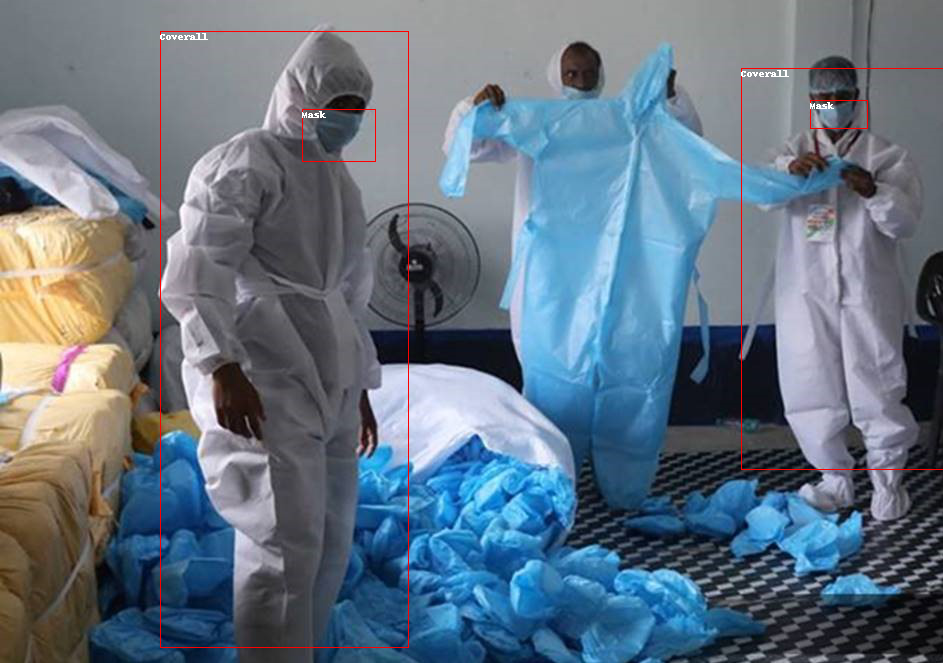

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [5]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [7]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [8]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [9]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]



{'pixel_values': tensor([[[ 1.5982,  1.5982,  1.5982,  ..., -1.2788, -1.2788, -1.2788],
          [ 1.5982,  1.5982,  1.5982,  ..., -1.2788, -1.2788, -1.2788],
          [ 1.5982,  1.5982,  1.5982,  ..., -1.2617, -1.2617, -1.2617],
          ...,
          [-0.8678, -0.8678, -0.8678,  ..., -1.2959, -1.2959, -1.2959],
          [-0.8507, -0.8507, -0.8507,  ..., -1.2959, -1.2788, -1.2788],
          [-0.8507, -0.8507, -0.8507,  ..., -1.2959, -1.2788, -1.2788]],
 
         [[ 2.0084,  2.0084,  2.0084,  ..., -1.1253, -1.1253, -1.1253],
          [ 2.0084,  2.0084,  2.0084,  ..., -1.1253, -1.1253, -1.1253],
          [ 2.0084,  2.0084,  2.0084,  ..., -1.1078, -1.1078, -1.1078],
          ...,
          [-0.6001, -0.6001, -0.6001,  ..., -1.1429, -1.1429, -1.1429],
          [-0.5826, -0.5826, -0.5826,  ..., -1.1429, -1.1253, -1.1253],
          [-0.5826, -0.5826, -0.5826,  ..., -1.1429, -1.1253, -1.1253]],
 
         [[ 2.1171,  2.1171,  2.1171,  ..., -0.9330, -0.9330, -0.9330],
          [ 

In [10]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [11]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=100,
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=10,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

Detected kernel version 4.19.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


ValueError: Expected y_min for bbox (0.564, 1.4433333333333334, 0.659, 1.6916666666666667, 2) to be in the range [0.0, 1.0], got 1.4433333333333334.

# scrap

In [6]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [7]:
x = cppe5["train"][0]['objects']['bbox']

In [9]:
x[0]

[302.0, 109.0, 73.0, 52.0]

In [8]:
list(x[0])

[302.0, 109.0, 73.0, 52.0]

# Segment anything

In [96]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-12 19:13:26--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Auflösen des Hostnamens dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)… 52.222.236.65, 52.222.236.115, 52.222.236.74, ...
Verbindungsaufbau zu dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.65|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 2564550879 (2,4G) [binary/octet-stream]
Wird in »sam_vit_h_4b8939.pth« gespeichert.

sam_vit_h_4b8939.pt 100%[===================>]   2,39G   107MB/s    in 28s     

2024-02-12 19:14:12 (87,1 MB/s) - »sam_vit_h_4b8939.pth« gespeichert [2564550879/2564550879]



In [2]:
import os
from PIL import Image
import shutil
from tqdm import tqdm
import numpy as np


In [23]:
import os
from PIL import Image
import shutil
from tqdm import tqdm

base_dir = '/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG9_sample'
target_dir = '/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG9_sample_day'
os.makedirs(target_dir, exist_ok=True)

for image_name in tqdm(os.listdir(base_dir)):
    if not image_name.endswith('.jpg'):
        continue
    image = Image.open(os.path.join(base_dir, image_name))
    variance = np.array(image.convert("RGB")).var(2).mean()
    if variance > 50:
        shutil.move(os.path.join(base_dir, image_name), os.path.join(target_dir, image_name))


  0%|          | 0/3334 [00:00<?, ?it/s]

100%|██████████| 3334/3334 [05:01<00:00, 11.07it/s]


In [20]:
# test = Image.open('/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG5_sample/Kamera120170327-164011-1490625611_frame_1838.jpg')
# test = Image.open('/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG5_sample/Kamera120170327-174011-1490629211_frame_7200.jpg')
# test = Image.open('/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG5_sample/Kamera120170327-161011-1490623811_frame_2129.jpg')
test = Image.open('/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG7_sample/Kamera120170606-151753-1496755073_frame_11043.jpg')
test = Image.open('/usr/users/henrich1/pig_data/data/images/unlabeled/W_DG5_7_9_sample/W_DG7_sample/Kamera120170608-041755-1496888275_frame_21387.jpg')
test = np.array(test.convert("RGB")).var(2).mean()

In [21]:
test

0.0

In [15]:
test[0, 0, :]

array([ 90, 102,  98], dtype=uint8)